In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import scipy
import xgboost as xgb
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [33]:
df = pd.read_csv('train.csv')

In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [35]:
df.shape

(404290, 6)

In [36]:
df = df.dropna(how="any").reset_index(drop=True)

In [37]:
df.shape

(404287, 6)

<AxesSubplot:xlabel='is_duplicate'>

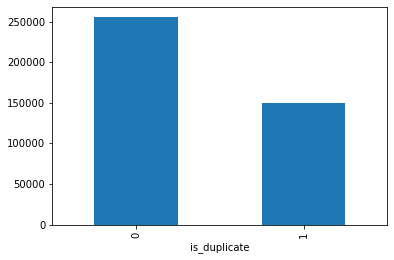

In [38]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [39]:
df['is_duplicate'].mean()

0.3692005926482919

In [40]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [19]:
#Number of Unique Questions

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qids = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))


Total number of  Unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.779322178205675%)

Max number of times a single question is repeated: 157



C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



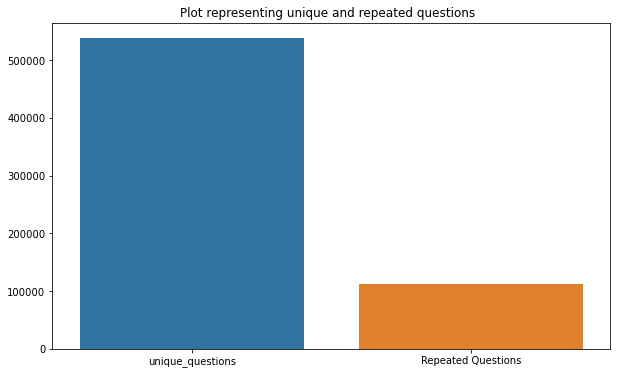

In [20]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qids , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [22]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Maximum number of times a single question is repeated: 157



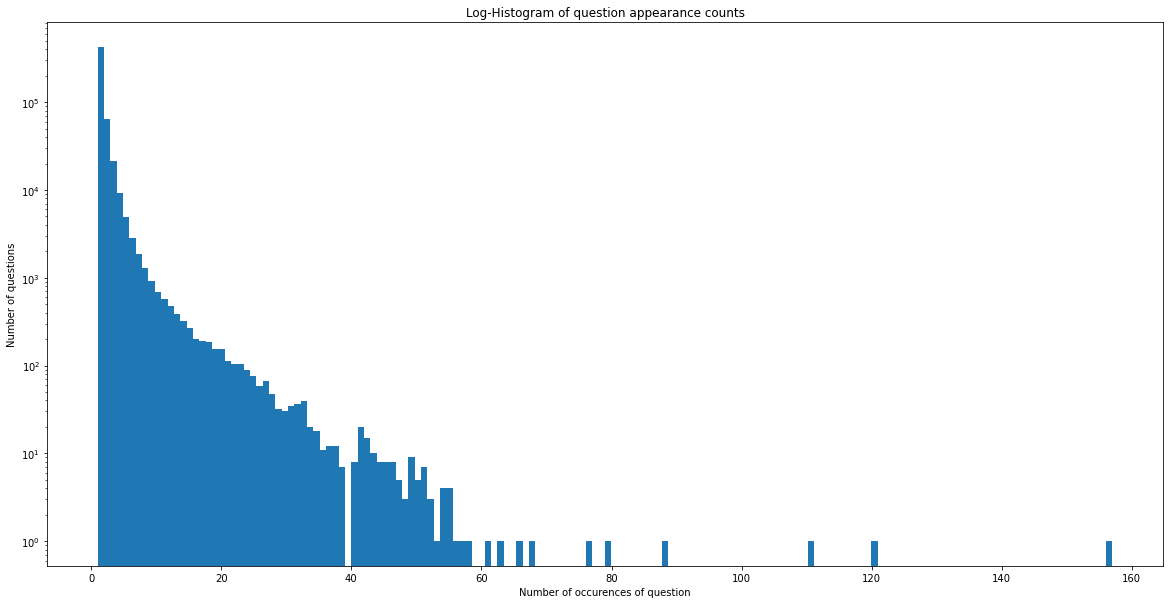

In [24]:
#Number of occurrences of each question

plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [41]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [42]:
#Cleaning


SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

from string import punctuation
stop_words = stopwords.words('english')

def clean(text, stem_words=True):

    
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    ps = PorterStemmer()
    
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
       # Return a list of words
    text = ' '.join([word for word in text.split(" ") if word not in stop_words]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text

    



In [43]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [44]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


#### Computing Word Mover's Distance (WMD)

The WMD measures the dissimilarity between two text documents the minimum amount of distance that the embedded words of one document need to reach the embedded words of another document.

In [92]:
question1 = 'What would a Trump presidency mean for current international master’s students on an F1 visa?'
question2 = 'How will a Trump presidency affect the students presently in US or planning to study in US?'

question1 = question1.lower().split()
question2 = question2.lower().split()

question1 = [w for w in question1 if w not in stop_words]
question2 = [w for w in question2 if w not in stop_words]

In [51]:
import gensim
#from smart_open import open
import smart_open
from gensim.models import Word2Vec
    
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [93]:
distance = model.wmdistance(question1, question2)
print('distance = %.4f' % distance)

distance = 1.8293


In [53]:
model.init_sims(replace=True)
distance = model.wmdistance(question1, question2)
print('normalized distance = %.4f' % distance)

normalized distance = 0.7589


In [14]:
question3 = 'Why am I mentally very lonely? How can I solve it?'
question4 = 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?'

question3 = question3.lower().split()
question4 = question4.lower().split()

question3 = [w for w in question3 if w not in stop_words]
question4 = [w for w in question4 if w not in stop_words]

distance = model.wmdistance(question3, question4)
print('distance = %.4f' % distance)

distance = 1.2637


In [15]:
model.init_sims(replace=True)
distance = model.wmdistance(question3, question4)
print('normalized distance = %.4f' % distance)

normalized distance = 1.2637


### soft cosine

In [16]:
from gensim import corpora
documents = [question1, question2, question3, question4]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Convert the sentences into bag-of-words vectors.
question1 = dictionary.doc2bow(question1)
question2 = dictionary.doc2bow(question2)
question3 = dictionary.doc2bow(question3)
question4 = dictionary.doc2bow(question4)

In [21]:
import gensim.downloader as api

w2v_model = api.load("glove-wiki-gigaword-50")
similarity_matrix = w2v_model.similarity_matrix(dictionary)

[==================================================] 100.0% 66.0/66.0MB downloaded


C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `similarity_matrix` (Method will be removed in 4.0.0, use gensim.models.keyedvectors.WordEmbeddingSimilarityIndex instead).



In [22]:
similarity_matrix

<25x25 sparse matrix of type '<class 'numpy.float32'>'
	with 47 stored elements in Compressed Sparse Column format>

In [23]:
from gensim.matutils import softcossim

similarity = softcossim(question1, question2, similarity_matrix)
print('similarity = %.4f' % similarity)

similarity = 0.4756


C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning:

Call to deprecated `softcossim` (Function will be removed in 4.0.0, use gensim.similarities.termsim.SparseTermSimilarityMatrix.inner_product instead).



In [25]:
similarity = softcossim(question3, question4, similarity_matrix)
print('similarity = %.4f' % similarity)

similarity = 0.0942


C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `softcossim` (Function will be removed in 4.0.0, use gensim.similarities.termsim.SparseTermSimilarityMatrix.inner_product instead).



### FuzzyWuzzy

In [26]:
from fuzzywuzzy import fuzz

In [27]:
question1 = 'What would a Trump presidency mean for current international master’s students on an F1 visa?'
question2 = 'How will a Trump presidency affect the students presently in US or planning to study in US?'
fuzz.ratio(question1, question2)

53

In [28]:
fuzz.partial_token_set_ratio(question1, question2)

100

In [29]:
question3 = 'Why am I mentally very lonely? How can I solve it?'
question4 = 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?'

In [30]:
fuzz.ratio(question3, question4)

28

In [31]:
fuzz.partial_token_set_ratio(question3, question4)

37

In [45]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


In [46]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [47]:
df.head()

,question1,question2,is_duplicate
0,what step step guide invest share market india?,what step step guide invest share market?,0
1,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


In [55]:
question1_vectors = np.zeros((df.shape[0], 300))

In [64]:
s = df.question1.values[0]
s

'what step step guide invest share market india?'

In [63]:
words = str(s).lower()
words = word_tokenize(words)
print('After tokenization',words)
words = [w for w in words if not w in stop_words]
words = [w for w in words if w.isalpha()]
M = []
for w in words:
    try:
        M.append(model[w])
    except:
        continue
print('M is',M)
M = np.array(M)
print(M.shape)
v = M.sum(axis=0)
print('v is ',v)
print(v / np.sqrt((v ** 2).sum()))

After tokenization ['what', 'step', 'step', 'guide', 'invest', 'share', 'market', 'india', '?']
M is [array([-0.07852414,  0.04130891,  0.04205321, -0.04391398, -0.07666337,
       -0.02772535,  0.03628485, -0.06810387,  0.02018926,  0.06289374,
        0.07889629, -0.0280975 ,  0.11685583, -0.02205002, -0.05582285,
        0.03795954,  0.0647545 , -0.03721523,  0.01432786, -0.06177729,
        0.07108109,  0.04205321,  0.04912411, -0.00632659,  0.03926207,
        0.04949626, -0.00059021, -0.01349052, -0.01767723,  0.05396209,
       -0.04075068,  0.01544432,  0.02902788,  0.03070257, -0.04949626,
       -0.00534969,  0.07777984,  0.04986841,  0.0202823 ,  0.02623674,
       -0.06884818, -0.00637311,  0.01553736, -0.00300048, -0.05991652,
       -0.0967596 , -0.10122543,  0.02605066, -0.09303808,  0.01693293,
       -0.0156304 ,  0.0647545 ,  0.0183285 , -0.12206596,  0.09750391,
        0.01153672, -0.02139876, -0.06363805, -0.00902469,  0.01302533,
       -0.08745579,  0.00225617, -

[-0.07935596  0.00800489 -0.02103714 -0.03883845 -0.04483481 -0.01925259
  0.04867395 -0.11526386  0.04551978  0.04358117 -0.04213486 -0.00308908
  0.08171021  0.02803501 -0.12324873  0.04750786  0.00612883  0.07197093
  0.01237812 -0.06814801  0.06642014  0.03058202  0.00994497 -0.03741679
  0.00998507  0.05633099 -0.04890388  0.07824679 -0.00266364  0.00111676
 -0.0269859  -0.01733499 -0.08769833  0.0226925  -0.07480001 -0.01817651
  0.00200575 -0.01337979  0.0788839   0.03975368 -0.01575316  0.01131196
  0.08025067  0.03912941 -0.03800185 -0.11024553 -0.05784887  0.03442508
 -0.06969875  0.03261765  0.02601599  0.04733303  0.00536089 -0.08837681
  0.04124222 -0.06399351 -0.03153509 -0.11747642  0.05659061 -0.03647447
 -0.07179376 -0.01691661 -0.02606656  0.03828829  0.00862713 -0.09080766
 -0.04057259 -0.01493397  0.02269049  0.06189456 -0.15054874 -0.00695064
  0.04560329 -0.0447641  -0.01829104 -0.04610755  0.04580667  0.07537878
  0.01094443  0.05701325 -0.01084713 -0.01266961  0

In [81]:
question1 = 'What would a Trump presidency mean for current international master’s students on an F1 visa?'
question2 = 'How will a Trump presidency affect the students presently in US or planning to study in US?'

In [85]:
a = {'question1': question1, 'question2': question2}
testdf = pd.DataFrame(a,columns = ['question1','question2'],index=[0])

In [86]:
testdf

,question1,question2
0,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...


In [87]:
testdf['len_q1'] = testdf.question1.apply(lambda x: len(str(x)))
testdf['len_q2'] = testdf.question2.apply(lambda x: len(str(x)))
testdf['diff_len'] = testdf.len_q1 - testdf.len_q2
testdf['len_char_q1'] = testdf.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
testdf['len_char_q2'] = testdf.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
testdf['len_word_q1'] = testdf.question1.apply(lambda x: len(str(x).split()))
testdf['len_word_q2'] = testdf.question2.apply(lambda x: len(str(x).split()))
testdf['common_words'] = testdf.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
testdf['fuzz_ratio'] = testdf.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
testdf['fuzz_partial_ratio'] = testdf.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
testdf['fuzz_partial_token_set_ratio'] = testdf.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
testdf['fuzz_partial_token_sort_ratio'] = testdf.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
testdf['fuzz_token_set_ratio'] = testdf.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
testdf['fuzz_token_sort_ratio'] = testdf.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [88]:
testdf

,question1,question2,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,93,91,2,25,24,15,17,4,53,54,100,56,61,56


In [89]:
def wmd(q1, q2):
    return model.wmdistance(q1, q2)

def norm_wmd(q1, q2):
    return norm_model.wmdistance(q1, q2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

### Word2Vec Modelling

In [95]:
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
testdf['wmd'] = testdf.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)

In [96]:
df.shape

(404287, 3)

### Normalized Word2vec Modeling

In [98]:
norm_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
norm_model.init_sims(replace=True)
#testdf['norm_wmd'] = testdf.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)

In [100]:
testdf

,question1,question2,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,wmd,norm_wmd
0,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,93,91,2,25,24,15,17,4,53,54,100,56,61,56,0.569327,0.209776


In [102]:
from tqdm import tqdm_notebook
question1_vectors = np.zeros((testdf.shape[0], 300))
for i, q in enumerate(tqdm_notebook(testdf.question1.values)):
    question1_vectors[i, :] = sent2vec(q)
    
question2_vectors  = np.zeros((testdf.shape[0], 300))
for i, q in enumerate(tqdm_notebook(testdf.question2.values)):
    question2_vectors[i, :] = sent2vec(q)

C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



C:\Users\Suraj\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [104]:
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from scipy.stats import skew, kurtosis

In [105]:
testdf['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
testdf['skew_q1vec'] = [skew(x) for x in np.nan_to_num(question1_vectors)]
testdf['skew_q2vec'] = [skew(x) for x in np.nan_to_num(question2_vectors)]
testdf['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(question1_vectors)]
testdf['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(question2_vectors)]

In [106]:
testdf

,question1,question2,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,93,91,2,25,24,15,17,4,...,10.389965,1.0,143.751566,0.772044,0.352782,0.403146,0.189724,0.253101,-0.082265,0.033484


### Training

In [109]:
df = pd.read_csv('features.csv')

In [111]:
df.head()

,Unnamed: 0,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,6,17,17,8,7,5,93,98,100,92,100,93
1,1,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,-36,17,24,5,10,3,66,85,100,82,91,64
2,2,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,10,17,16,8,6,3,48,45,100,80,67,67
3,3,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,-11,14,21,8,5,0,11,19,32,29,28,25
4,4,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,33,24,16,11,6,1,34,50,100,71,63,48


In [112]:
def wmd(q1, q2):
    return model.wmdistance(q1, q2)

def norm_wmd(q1, q2):
    return norm_model.wmdistance(q1, q2)


def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [113]:
df['wmd'] = df.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)
df['norm_wmd'] = df.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)

TypeError: object of type 'float' has no len()

In [ ]:
question1_vectors = np.zeros((df.shape[0], 300))
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q)
    
question2_vectors  = np.zeros((df.shape[0], 300))
for i, q in enumerate(tqdm_notebook(df.question2.values)):
    question2_vectors[i, :] = sent2vec(q)